In [62]:
!pip install pandas matplotlib numpy
!pip install scikit-survival

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [64]:
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")  # Load your CSV file
X = data.drop(columns=["id", "time", "status"])

from sksurv.util import Surv
y = Surv.from_arrays(event=data["status"] == 1, time=data["time"])

# Example of handling 'gender' with OrdinalEncoder, adjust for other columns as needed
from sklearn.preprocessing import OrdinalEncoder

Xt = X  # Use X or continue with OneHotEncoder if you need further encoding

In [65]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)
print(X_train.shape)

# Fit the Random Survival Forest on the reduced dataset

(514, 8)


In [66]:
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, max_depth=10, n_jobs=2, random_state=random_state)
rsf.fit(X_train, y_train)


RandomSurvivalForest(max_depth=10, min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=2, random_state=20)

In [67]:
rsf.score(X_test, y_test)

0.6796383647798742

In [68]:
X_test_sorted = X_test.sort_values(by=["nodes", "prog"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,treat,age,men,size,grade,nodes,prog,oest
363,0,51,1,21,3,1,0,0
121,0,45,1,29,2,1,0,0
319,0,56,2,40,3,1,0,3
24,0,65,2,70,3,26,2,64
8,0,80,2,39,2,30,0,59
226,1,72,2,34,3,36,2,1091


In [69]:
pd.Series(rsf.predict(X_test_sel))

0    103.137789
1     88.245962
2    117.152307
3    173.338766
4    172.783301
5    149.263481
dtype: float64

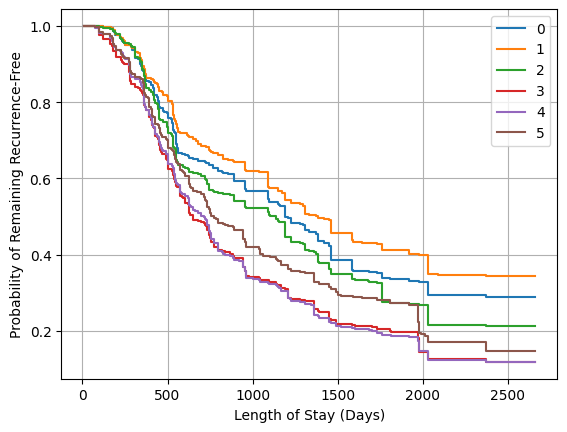

In [70]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Probability of Remaining Recurrence-Free")
plt.xlabel("Length of Stay (Days)")
plt.legend()
plt.grid(True)

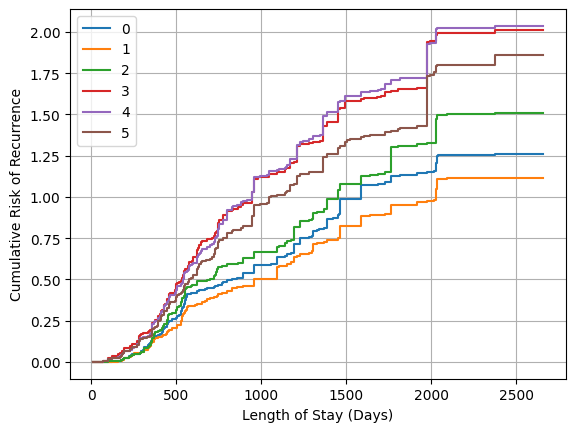

In [71]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative Risk of Recurrence")
plt.xlabel("Length of Stay (Days)")
plt.legend()
plt.grid(True)

In [72]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=random_state)

In [73]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
nodes,0.068894,0.018375
prog,0.015383,0.014349
age,0.012448,0.005967
treat,0.007862,0.004344
grade,0.005320,0.003738
men,0.000183,0.000711
size,-0.005005,0.008147
oest,-0.005608,0.014885
